# Plotting a Mueller Matrix Model

Before fitting, you can see how your calibration data fits a model.

In [50]:
from pyPolCal.utils import *
from pyPolCal.csv_tools import read_csv
from pyPolCal.constants import wavelength_bins # CHARIS wavelength bins
from pyPolCal.fitting import model, plot_data_and_model
from pathlib import Path

# Step 1: Read in Data
The `read_csv` function reads in relevant data generated from the `write_fits_info_to_csv()` and processes it into three things: interleaved single sums/differences , interleaved errors on those from the apertures (recently I have decided to not use these in internal calibrations since they are so tiny for large apertures), and a `configuration_list` for each single sum/difference combo. The `configuration_list` includes HWP and derotator angles by default, but can be modified by the `mode` argument in `read_csv`. It is a list of dictionaries, one dictionary for each single sum/difference combo.

NON CHARIS USERS: This will be more involved. You will have to make your own CSV writer and modify the read function to read in relevant parameters. I made the `single_sum_and_diff()` function in `csv_tools.py` compatible with different apertures, so this should help with making your own csv writer.

In [8]:
# Using wavelength bin 15 as an example to plot

filepath = Path('/home/thomasmc/nbs_in/pol/csvs/bin15.csv')

interleaved_values, interleaved_stds, configuration_list = read_csv(filepath)

# Step 2: Generate the System Mueller Matrix
See `system_mueller_matrix_tutorial.ipynb` for more info on this.

In [40]:
# The configuration list will modify hwp_theta and image_rotator_theta which is why they are zero
# The image rotator and HWP phi's are also set to zero, I will explain this in the next step

offset_imr = 0.18563 # derotator offset
offset_hwp = -0.87823 # HWP offset
offset_cal = -0.44630 # calibration polarizer offset
imr_theta = 0 
hwp_theta = 0 

system_dict = {
        "components" : {
            "wollaston" : {
            "type" : "wollaston_prism_function",
            "properties" : {"beam": 'o'}, 
            "tag": "internal",
            },
            'nbs_rot' : {
                "type" : "rotator_function",
                "properties" : {'pa':90},
                "tag": "internal",
            },
            "image_rotator" : {
                "type" : "general_retarder_function",
                "properties" : {"phi": 0, "theta": imr_theta, "delta_theta": offset_imr},
                "tag": "internal",
            },
            "hwp" : {
                "type" : "general_retarder_function",
                "properties" : {"phi": 0, "theta": hwp_theta, "delta_theta": offset_hwp},
                "tag": "internal",
            },
            "lp" : {  # calibration polarizer for internal calibration source
                "type": "diattenuator_retarder_function",
                "properties": {"epsilon": 1, "delta_theta": offset_cal},
                "tag": "internal"},
            
        }}

# Generate the system MM and evaluate to check everything looks good
system_mm = generate_system_mueller_matrix(system_dict)
print(system_mm.evaluate())

[[ 6.06735946e-05  6.06662320e-05 -9.45184102e-07  0.00000000e+00]
 [ 6.06735946e-05  6.06662320e-05 -9.45184102e-07  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]


# Step 3: Generate Modeled Parameters
There are a couple things here that seem useless, but are just convention because these modeling functions are used in larger fitting functions. You must define some `p` values which will update what is in your above `system_mm`. For our purposes here, it makes no difference if you put this in the `system_mm` above or in the `p` values/keys. You will first define `p_keys` which is a list of the form `[['component1_name', 'parameter1_name'],['component2_name', 'parameter2_name'],..]` then define `p_values` which are the corresonding numerical values to those keys `[parameter1_value, parameter2_value]`

In [48]:
# I'm going to generate retardances based on old physical models

from pyMuellerMat.physical_models.charis_physical_models import * # where my physical models are stored

hwp_phi = HWP_retardance(wavelength_bins,1.66725,1.30159)[15] # bin 15
imr_phi = IMR_retardance(wavelength_bins,259.14673)[15] # bin 15

p_keys = [['hwp','phi'],['image_rotator','phi']] # generating keys

p_values = [hwp_phi,imr_phi] # corresponding values


Now I will generate modeled Wollaston L/R beam intensities using the `model()` function and then process those into single sums and differences using the `process_model` argument. My input Stokes vector will be unpolarized.

In [52]:
modeled_interleaved = model(p_values,p_keys,system_mm,configuration_list,s_in=[1,0,0,0],process_model=process_model)

# Step 4: Plot
There are a couple of plotting functions you can play with in `plotting.py`. The one I'm going to use puts the HWP angle on the x-axis. The `include_sums` keyword should always be set to false with CHARIS. This includes modeled double sums, which are nonsense for CHARIS.

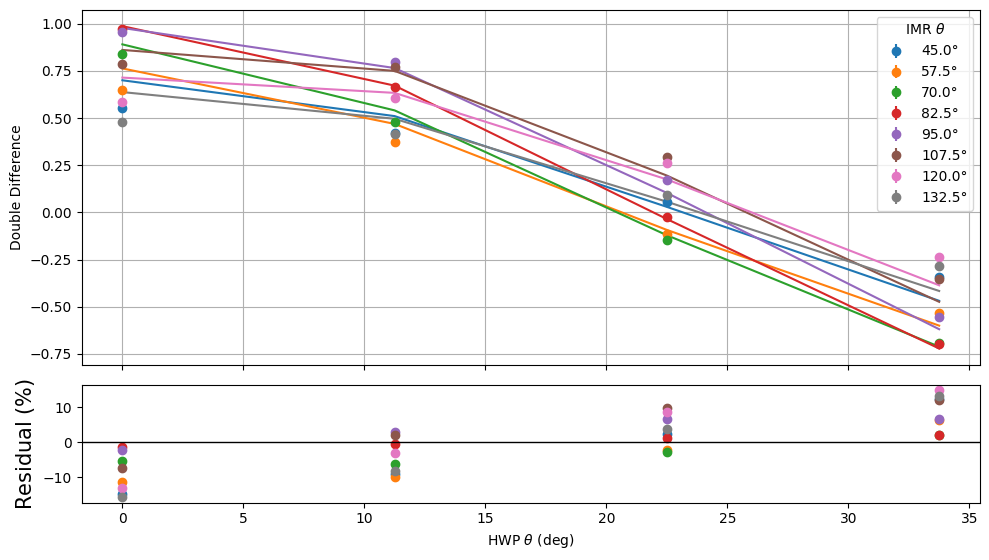

In [54]:
fig, ax = plot_data_and_model(interleaved_values,modeled_interleaved,configuration_list,include_sums=False)